In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Descomprimimos el archivo en el que tenemos todos los datos necesarios para la práctica
!unzip /content/drive/MyDrive/Datos/Practica1/archive-intel.zip

Archive:  /content/drive/MyDrive/Datos/Practica1/archive-intel.zip
replace archive-intel/seg_test/seg_test/buildings/20057.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Preparación de las imagenes en crudo en su representación en tensor
from keras.preprocessing.image import ImageDataGenerator
#Con este generador, podremos recorrer los datos en lotes, y en cada iteración, el generador aplicará
#las técnicas de aumento de datos especificadas para generar imágenes aumentadas

In [ ]:
#Para normalizar los valores de los píxeles en las imágenes
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    '/content/archive-intel/seg_train/seg_train', #Ruta del directorio donde se encuentran las imágenes de entrenamiento
    target_size=(200, 200), #Las imágenes se redimensionarán a una altura y ancho de 200 píxeles
    batch_size=200, #Número de imágenes en cada lote que se utilizará para el entrenamiento
    class_mode='categorical') #Tarea de clasificación categórica (multiclase)

Found 14034 images belonging to 6 classes.


In [ ]:
validation_generator = test_datagen.flow_from_directory(
    '/content/archive-intel/seg_test/seg_test', #Ruta del directorio donde se encuentran las imágenes de prueba o validación
    target_size=(200, 200), #Las imágenes se redimensionarán a una altura y ancho de 200 píxeles
    batch_size=200, #Número de imágenes en cada lote que se utilizará para la evaluación
    class_mode='categorical') #Tarea de clasificación categórica (multiclase)

Found 3000 images belonging to 6 classes.


In [ ]:
# Veamos el contenido de uno de los generators e imprimimos la forma (shape) del lote de datos y el lote de etiquetas
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (200, 200, 200, 3)
labels batch shape: (200, 6)


In [ ]:
#Arquitectura VGG19 como base convolucional, con 19 capas
from keras.applications import VGG19
#Inicializamos el modelo con los pesos preentrenados en el conjunto de datos de ImageNet
#Omitimos la capa densa superior (capa de clasificación) del modelo original
#Especificamos el tamaño de la entrada de las imágenes, 200x200 píxeles y 3 canales (RGB)
conv_base = VGG19(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

In [ ]:
#Resumen de la arquitectura de la base convolucional VGG19
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [ ]:
#Este enfoque, conocido como "fine-tuning", permite congelar algunas capas y permitir que otras se ajusten durante el entrenamiento

conv_base.trainable = True #Para permitir el ajuste fino en la base convolucional
#Solo se entrenan las últimas 4 capas convolucionales mientras se congelan las demás capas
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        layer.trainable = True
    if layer.name == 'block5_conv2':
        layer.trainable = True
    if layer.name == 'block5_conv3':
        layer.trainable = True
    if layer.name == 'block5_conv4':
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base) #Agregamos la base convolucional VGG19 al modelo
model.add(layers.GlobalAveragePooling2D()) #Calcula el valor promedio para cada mapa de características, reduciendo las dimensiones espaciales de los mapas de características a un solo valor por canal
model.add(layers.Dense(6, activation='softmax')) #Capa de salida con 6 neuronas (tenemos 6 clases), y función de activación softmax porque es clasificación multiclase

In [ ]:
#Resumen del modelo
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 6, 6, 512)         20024384  
                                                                 
 global_average_pooling2d_2  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 20027462 (76.40 MB)
Trainable params: 2362886 (9.01 MB)
Non-trainable params: 17664576 (67.39 MB)
_________________________________________________________________


In [ ]:
# Configuración del modelo para entrenamiento
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import LearningRateScheduler


# Defino una función de decaimiento para el learning rate
def learning_rate_scheduler(epoch, lr):
    return lr * 0.95  # Reduce el learning rate en un 5% en cada época

# Compilo el modelo con el optimizador Adam y un learning rate inicial
#La entropía cruzada categórica ('categorical_crossentropy') es comúnmente utilizada en este tipo de problemas (multiclase)
#Monitoreamos la precisión durante el entrenamiento
initial_learning_rate = 0.001
optimizer = optimizers.Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])

# Definimos el callback para el learning rate decay
lr_decay_callback = LearningRateScheduler(learning_rate_scheduler, verbose=1)


In [ ]:
# Vamos a entrenar la red neuronal con el generator que configuramos más arriba
history = model.fit_generator(train_generator, steps_per_epoch=70, epochs=10, validation_data=validation_generator, validation_steps=15, callbacks=[lr_decay_callback])

<ipython-input-55-a2e9a6338e89>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=70, epochs=10, validation_data=validation_generator, validation_steps=15, callbacks=[lr_decay_callback])



Epoch 1: LearningRateScheduler setting learning rate to 0.0009500000451225787.
Epoch 1/10
70/70 [==============================] - 103s 1s/step - loss: 0.5355 - acc: 0.7946 - val_loss: 0.3582 - val_acc: 0.8710 - lr: 9.5000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009025000152178108.
Epoch 2/10
70/70 [==============================] - 82s 1s/step - loss: 0.3310 - acc: 0.8825 - val_loss: 0.3277 - val_acc: 0.8790 - lr: 9.0250e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008573750033974647.
Epoch 3/10
70/70 [==============================] - 81s 1s/step - loss: 0.2856 - acc: 0.8988 - val_loss: 0.3019 - val_acc: 0.8887 - lr: 8.5737e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0008145062311086804.
Epoch 4/10
70/70 [==============================] - 81s 1s/step - loss: 0.2589 - acc: 0.9083 - val_loss: 0.3190 - val_acc: 0.8777 - lr: 8.1451e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0007737808919046074.
Epoch 5/10


# Vamos a ver las graficas de entrenamiento

In [ ]:
history_dict = history.history

In [ ]:
#Para obtener las claves disponibles en este diccionario
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])

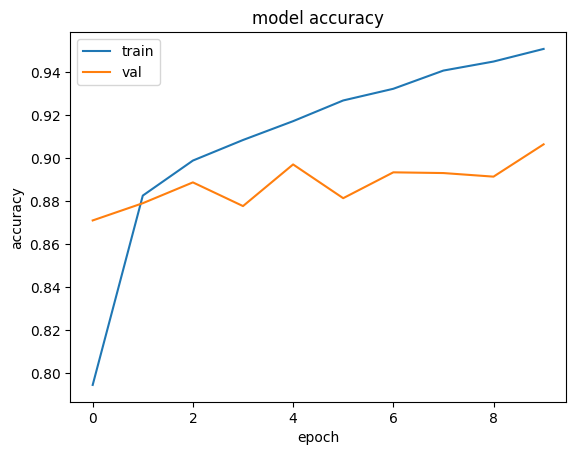

In [ ]:
#Gráfica de la precisión del modelo
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy') #Eje y (accuracy): Representa la precisión del modelo
plt.xlabel('epoch') #Eje x (epoch): Representa las épocas del entrenamiento
plt.legend(['train', 'val'], loc='upper left')
plt.show()

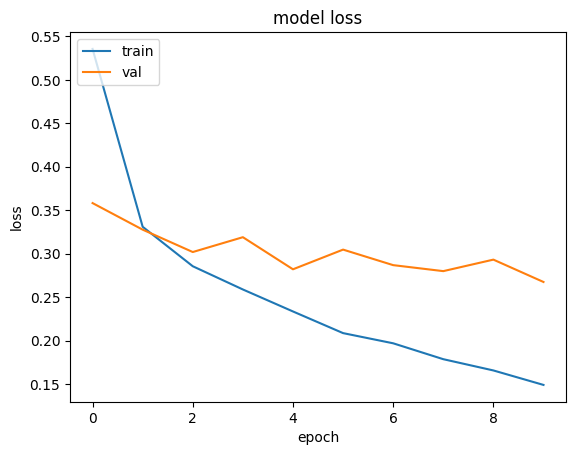

In [ ]:
#Gráfica de la pérdida del modelo
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss') #Eje y (loss): Representa la pérdida del modelo
plt.xlabel('epoch') #Eje x (epoch): Representa las épocas del entrenamiento
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#Para evaluar el rendimiento del modelo en un conjunto de datos que no se ha visto durante el entrenamiento
test_generator = test_datagen.flow_from_directory(
    '/content/archive-intel/seg_test/seg_test', #Ruta del directorio donde se encuentran las imágenes de prueba
    target_size=(200, 200), #Las imágenes se redimensionarán a una altura y ancho de 200 píxeles
    batch_size=32, #Número de imágenes en cada lote que se utilizará para la evaluación
    class_mode='categorical') #Tarea de clasificación categórica (multiclase)

Found 3000 images belonging to 6 classes.


In [ ]:
#Estimar la preción al predecir todo el dataset, es decir, evaluamos el rendimiento final del modelo en datos no vistos
scores = model.evaluate(test_generator)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

94/94 [==============================] - 13s 139ms/step - loss: 0.2675 - acc: 0.9063
acc: 90.63%
